In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/home/daniel/Documents/dark-matter-halos/src


In [30]:
from classical.classical_approach import *
from knn import knn

root_path = Path().resolve().parents[0]
data_path = root_path / "data"
halos_path = data_path / "halos.pkl"


In [31]:
with open(halos_path, "rb") as f:
  particles, halo_slice  = pickle.load(f)

train_indices, test_indices = train_test_split(jnp.arange(len(particles)), test_size=0.5, random_state=42)

labels = jnp.log10(
    halo_slice["GroupStellarMass"] * 1e10 / 0.677
)  # label by logMstar
logc = jnp.log10(
    halo_slice["SubhaloVmax"]
    / jnp.sqrt(G * halo_slice["Group_M_Mean200"] / halo_slice["Group_R_Mean200"])
)
logm = jnp.log10(jnp.array([particle["count"] for particle in particles]))


train_labels, test_labels = labels[train_indices], labels[test_indices]
train_logc, test_logc = logc[train_indices], logc[test_indices]
train_logm, test_logm = logm[train_indices], logm[test_indices]
data = jnp.stack([logc, logm], axis=1)

In [59]:
train_x = jnp.stack([train_logc, train_logm], axis=-1)
mean_x = train_x.mean(axis=0, keepdims=True)
std_x = train_x.std(axis=0, keepdims=True)

data_transformed = (data - mean_x) / std_x
train_transformed = data_transformed[train_indices]
test_transformed = data_transformed[test_indices]
distance_matrix = jnp.linalg.norm(data_transformed[:, None] - data_transformed[None], axis=-1)


[Text(0.5, 0, 'True log Stellar Mass'),
 Text(0, 0.5, 'Predicted log Stellar Mass')]

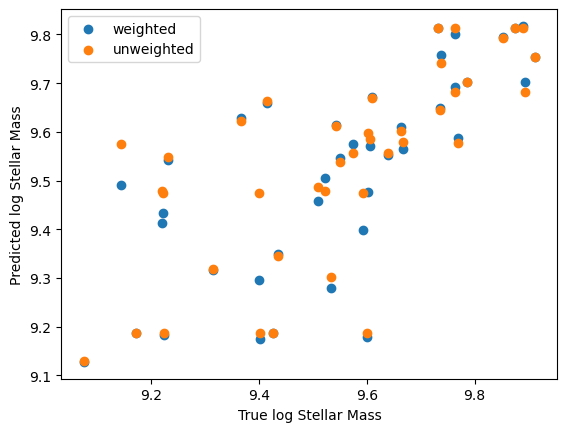

In [66]:
pred_labels_weighted = knn.regression2(train_labels, distance_matrix, train_indices, test_indices, weighted=True)
pred_labels_unweighted = knn.regression2(train_labels, distance_matrix, train_indices, test_indices, weighted=False)

fig, ax = plt.subplots()

ax.scatter(test_labels, pred_labels_weighted, label="weighted")
ax.scatter(test_labels, pred_labels_unweighted, label="unweighted")

ax.legend()
ax.set(xlabel="True log Stellar Mass", ylabel="Predicted log Stellar Mass")